<center>
<font style="font-family: 'Helvetica'" color="blue" size="5">
<b>Schneider Electric European Hackaton 2023 </b><br>
</font>
<br>
</center>

<font style="font-family: 'Helvetica'" color="blue" size="4">
    <b>Machine Dreamers Team </b><br>
</font>
<br>


<font style="font-family: 'Helvetica'" color="blue" size="2">
<b>
Daniel Espinoza <br>
Juan Neuenschwander <br>
Pablo Ruiz<br>
    </b>   
</font>

    

    



<center>

# Data Processing
    
</center>


In [164]:
# Setting up libraries
#!pip install pandas
#!pip install json

In [193]:
# Imports
import os
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
from functools import reduce

### Reading CSV Files

First, we need to define the folder that contains every .csv file we want to read. This folder will include every file downloaded by the data ingestion code.

In [166]:
#Directory where raw CSV datasets are stored
directory = "../jupyter_notebook/data_samples"

We retrieve information to examine the datasets that the data ingestion code is downloading.

In [167]:
#Counters
counter_gen = 0
counter_load = 0

#Reading all .csv files in the specified directory. 
files = [archivo for archivo in os.listdir(directory) if archivo.endswith('.csv')]

# Itera sobre los archivos y cuenta según el prefijo
for file in files:
    if file.startswith('gen'):
        counter_gen += 1
    elif file.startswith('load'):
        counter_load += 1

unique_countries = set()
unique_type_energy = set()

# Itera sobre los archivos y extrae información
for file in files:
    if file.startswith('gen'):
        # Divide el nombre del archivo en partes usando '_' como separador
        parts = file.split('_')
        
        # Asegúrate de que haya suficientes partes y que el formato sea correcto
        if len(parts) == 3 and parts[0] == 'gen':
            country = parts[1]
            energy_tpye = parts[2].split('.')[0]  # Elimina la extensión .csv
            unique_countries.add(country)
            unique_type_energy.add(energy_tpye)

# Imprime los resultados
print("-----"+"\033[1m" +"Files Information" + "\033[0m"+"-----")
print(f'Total Files "gen": {counter_gen}')
print(f'Total Files "load": {counter_load}'+"\n")
print("-----"+"\033[1m" +"Countries Information" + "\033[0m"+"-----")
print('Number of countries:', len(list(unique_countries)))
print('Countries:', list(unique_countries),"\n")
print("-----"+"\033[1m" +"Energy Type Information" + "\033[0m"+"-----")
print('Number of energy type:', len(list(unique_type_energy)))
print('Energy Type:', list(unique_type_energy))


-----Files Information-----
Total Files "gen": 105
Total Files "load": 9

-----Countries Information-----
Number of countries: 9
Countries: ['PO', 'DK', 'UK', 'DE', 'SP', 'HU', 'IT', 'NE', 'SE'] 

-----Energy Type Information-----
Number of energy type: 20
Energy Type: ['B05', 'B08', 'B20', 'B07', 'B19', 'B16', 'B13', 'B17', 'B06', 'B15', 'B01', 'B02', 'B10', 'B14', 'B12', 'B09', 'B03', 'B04', 'B11', 'B18']


As seen above, there are multiple files for generation and nine for load. We can infer that the generation is categorized by the type of energy (20 types of energy datasets) and countries (9 countries).

### Initial Exploration Data Analysis - Generation Files

We know that to obtain the number of complete hourly data points for a year, according to the dataset's periodicity, we will need the data quantity as indicated in the following table:

| Number of Samples | Periodicity |
|:---------:|:--------:|
|  35,040 | 15 minutes |
|  17,462 | 30 minutes | 
|  8,760  | 60 minutes | 



We read one of the files as an example to show how the exploration was.

In [168]:
# Reading one specific sample
filename='gen_DE_B19'

sample = pd.read_csv(f"../jupyter_notebook/data_samples/{filename}.csv")

# We save the name of country and type of energy from the filename.
_, country, energy_type = filename.split('_')
energy_type = energy_type.replace('.csv', '') # Remove the file extension

In [169]:
#We create two columns to indentify the country and type of energy
sample['CountryCode'] = country
sample['EnergyTypeCode'] = energy_type

When we see the number of rows, we can notice that we have the double of rows neccesary for having complete information for 15 minutes periodicity, so we can infer that the whole data is duplicateed.

In [170]:
# Number of rows and columns.
sample.shape

(70080, 8)

We print the dataframe so we can explore the structure and the type of values of the variables.

In [171]:
# Printing a sample
sample

,StartTime,EndTime,AreaID,UnitName,PsrType,quantity,CountryCode,EnergyTypeCode
0,2021-12-31T23:45+00:00Z,2022-01-01T00:00+00:00Z,10Y1001A1001A83F,MAW,B19,24850,DE,B19
1,2022-01-01T00:00+00:00Z,2022-01-01T00:15+00:00Z,10Y1001A1001A83F,MAW,B19,24604,DE,B19
2,2022-01-01T00:15+00:00Z,2022-01-01T00:30+00:00Z,10Y1001A1001A83F,MAW,B19,24177,DE,B19
3,2022-01-01T00:30+00:00Z,2022-01-01T00:45+00:00Z,10Y1001A1001A83F,MAW,B19,23491,DE,B19
4,2022-01-01T00:45+00:00Z,2022-01-01T01:00+00:00Z,10Y1001A1001A83F,MAW,B19,23528,DE,B19
...,...,...,...,...,...,...,...,...
70075,2022-12-31T22:30+00:00Z,2022-12-31T22:45+00:00Z,NaN,MAW,B19,0,DE,B19
70076,2022-12-31T22:45+00:00Z,2022-12-31T23:00+00:00Z,NaN,MAW,B19,0,DE,B19
70077,2022-12-31T23:00+00:00Z,2022-12-31T23:15+00:00Z,NaN,MAW,B19,0,DE,B19
70078,2022-12-31T23:15+00:00Z,2022-12-31T23:30+00:00Z,NaN,MAW,B19,0,DE,B19


As we can see we have some NaN values with dates that seems to be duplicated, we will count number of values for each "EndTime" value.

In [172]:
# Grouping by to see if the values are repeated
sample.groupby('EndTime').count().head(5)

,StartTime,AreaID,UnitName,PsrType,quantity,CountryCode,EnergyTypeCode
EndTime,,,,,,,
2022-01-01T00:00+00:00Z,2,1,2,2,2,2,2
2022-01-01T00:15+00:00Z,2,1,2,2,2,2,2
2022-01-01T00:30+00:00Z,2,1,2,2,2,2,2
2022-01-01T00:45+00:00Z,2,1,2,2,2,2,2
2022-01-01T01:00+00:00Z,2,1,2,2,2,2,2


We see that we have duplicated values for all the dataframe so we will drop the NaN values and stay with the ones that have the complete information.

In [173]:
#Dropping the repeated values and checking
sample.dropna(inplace=True)
sample.groupby('EndTime').count().head(5)

,StartTime,AreaID,UnitName,PsrType,quantity,CountryCode,EnergyTypeCode
EndTime,,,,,,,
2022-01-01T00:00+00:00Z,1,1,1,1,1,1,1
2022-01-01T00:15+00:00Z,1,1,1,1,1,1,1
2022-01-01T00:30+00:00Z,1,1,1,1,1,1,1
2022-01-01T00:45+00:00Z,1,1,1,1,1,1,1
2022-01-01T01:00+00:00Z,1,1,1,1,1,1,1


Now we can see that the amount of values that the dataset have is the amount of values corresponding to 15 minutes periodicity , this means that if we resample we will have the complete information for a year.

In [174]:
# Number of rows and columns after cleaning duplicates
sample.shape

(35040, 8)

We will print the data type for each variable, but we think the structure should be like this:

| Name of the variable | Data Type | Definition |
|:---------:|:--------:|:--------:|
|  StartTime | datetime | Start Time of the measure of the energy |
|  EndTime | datetime | End Time of the measure of the energy |
|  AreaID  | string | ID of the area we are measuring |
|  UnitName  | string | Unit of Measure (MAW: Megawatt)  |
|  PsrType  | string | Type of energy |
|  quantity  | int64 | Amount of energy (MAW) |




In [175]:
# Printing datatype and amount of values
sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 0 to 35039
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   StartTime       35040 non-null  object
 1   EndTime         35040 non-null  object
 2   AreaID          35040 non-null  object
 3   UnitName        35040 non-null  object
 4   PsrType         35040 non-null  object
 5   quantity        35040 non-null  int64 
 6   CountryCode     35040 non-null  object
 7   EnergyTypeCode  35040 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.4+ MB


We see that we have to change datatype for "StartTime" and "EndTime" to be datetime data type.

In [176]:
#We define a date_parser, in this case we are omitting the time zone
#information since all countries share the same time zone.
date_parser = lambda x: pd.to_datetime(x[:22])

In [177]:
#Transform the column to datetime data type.
sample['EndTime'] = sample['EndTime'].apply(lambda x: pd.to_datetime(x[:22]))

#Transform the column to datetime data type.
sample['StartTime'] = sample['StartTime'].apply(lambda x: pd.to_datetime(x[:22]))

We are going to detect in what periodicity is the dataset we are reading, if we have more than one periodicity in the dataset we will select the minimun.

For this first we are going to calculate a new column that contains the difference between the actual row and the previous row of the "EndTime" column.

In [178]:
# Calculating the time difference in seconds, dividing by 60
# to obtain minutes
sample['TimeDifference'] = sample['EndTime'].diff().dt.total_seconds() / 60

 As we can see , the new column is giving us the periodicity (in this case 15 minutes) of the sample we are analyzing.

In [179]:
# Printing Time and Periodicity
sample[['EndTime','TimeDifference']].head(5)

,EndTime,TimeDifference
0,2022-01-01 00:00:00+00:00,NaN
1,2022-01-01 00:15:00+00:00,15.0
2,2022-01-01 00:30:00+00:00,15.0
3,2022-01-01 00:45:00+00:00,15.0
4,2022-01-01 01:00:00+00:00,15.0


Then we are going to select the minimum value of this column, which gives us our desired periodicity (15, 30, or 60 minutes).

In [180]:
# Sampling period we are going to use to sample
sampling_period = int(df.loc[(df['TimeDifference'] > 0) & (df['TimeDifference'] <= 60), 'TimeDifference'].min())

In [181]:
# We have to set the EndTime as index so we can do the resampling.
sample.set_index('EndTime', inplace=True)

In [182]:
#We change the type of "sampling_period" to string.
sampling_period=str(sampling_period)

# We use the sampling_period obtained to resample.
sample = sample.resample(f'{sampling_period}T').asfreq()

Now that we have completed the series by filling in missing periods through resampling, the next step is to assign an hour value to each period. This will help us identify and handle periods with missing values. Additionally, if there are periods with no values, we can assume that there is no information available for those specific time intervals and choose not to include them in our analysis.

To accomplish this, we have added a new column named 'Hour' to the DataFrame, which represents the hour of the day corresponding to each period. This additional information allows us to detect missing values more effectively and make informed decisions about how to handle them.

With the 'Hour' column in place, we can proceed to analyze and address missing or incomplete data based on the hour information associated with each period.

In [183]:
# Extracting the Date-Hour for each column (without minutes)
sample['DateHour'] = sample.index.floor('H')

In [184]:
# Reset index.
sample.reset_index('EndTime', inplace=True)

To identify whether a specific hour has missing values that need imputation or if it has no values and should be excluded from consideration, we will calculate a new column named "HourlySum." This column will represent the accumulated "quantity" for each date-hour group.

The "HourlySum" column is derived by summing the "quantity" values within each group defined by the combination of date and hour. This cumulative sum provides insights into the total quantity of energy for each specific date and hour. By analyzing the "HourlySum" column, we can efficiently identify periods with missing values or determine if certain hours have no recorded information.

This information will guide us in making decisions about imputing missing values and handling periods with no available data.







| Condition | Description | Action |
|:---------:|:--------:|:--------:|
|  HourlySum = 0 | No information for this group | Drop group |
|  HourlySum > 0 | Group with information|  IF NaNs, impute. |



In [185]:
# Group by DateHour and accumulate values
grouped_df = sample.groupby('DateHour')['quantity'].sum().reset_index()

# Rename quantity with HourlySum
grouped_df = grouped_df.rename(columns={'quantity': 'HourlySum'})

# Merge the values we obtained to the principal dataframe
sample = pd.merge(sample, grouped_df, how='left', left_on='DateHour', right_on='DateHour')

We stay with the values that have at least one value in the hour group (HourlySum !=0) and that are not NaN values (quantity!=NaN)

In [186]:
# Filtering to obtain the existing values
sample=sample[~((sample['quantity'].isnull())&(sample['HourlySum']==0))]

Now we are going to use the function "interpolate" to impute the missing values using the nearest existing values

In [187]:
# Interpolate for imputing missing values
sample.interpolate(method='linear', limit_direction='both', inplace=True)

We have to set EndTime as index again so this time we can resample for 1 hour periodicity 

In [188]:
# Setting EndTime as index
sample.set_index('EndTime',inplace=True)

For resampling we are going to separate categorical columns and numerical columns, for numerical we will accumulate the values and for categorical we will choose the last value of the group.

In [189]:
# Numeric columns
numeric_cols = sample.select_dtypes(include=['number'])

# Categoric columns
categorical_cols = sample.select_dtypes(exclude=['number', 'datetime64[ns]', 'bool'])

In [190]:
# Resample the numeric columns and sum
resampled_df_num = numeric_cols.resample('H').sum()

# Resample the categorical columns.
# Here, we take the first value. Adjust the method 
# if needed (e.g., 'last', or a custom function to get the mode)
resampled_df_cat= categorical_cols.resample('H').last()

In [191]:
# Resampled dataframe
resampled_df = pd.concat([resampled_df_num, resampled_df_cat], axis=1)

We can see that we have 8760 values (whole year data in hours) with the accumulated quantity of power consumption (MAW) per hour for one country and for one type of energy.

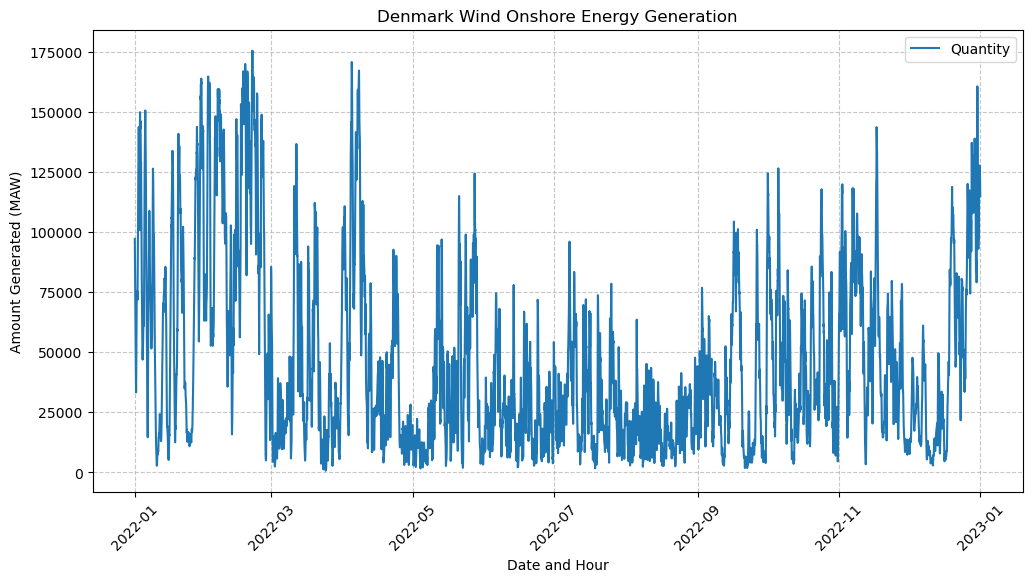

In [203]:
# Figure size
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(resampled_df.index, resampled_df['quantity'], label='Quantity')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Set ticks
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Add labels and title
ax.set_xlabel('Date and Hour')
ax.set_ylabel('Amount Generated (MAW)')
ax.set_title('Denmark Wind Onshore Energy Generation')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [192]:
resampled_df

,quantity,TimeDifference,HourlySum,StartTime,AreaID,UnitName,PsrType,CountryCode,EnergyTypeCode,DateHour
EndTime,,,,,,,,,,
2022-01-01 00:00:00+00:00,97122,60.0,388488,2022-01-01 00:30:00+00:00,10Y1001A1001A83F,MAW,B19,DE,B19,2022-01-01 00:00:00+00:00
2022-01-01 01:00:00+00:00,92456,60.0,369824,2022-01-01 01:30:00+00:00,10Y1001A1001A83F,MAW,B19,DE,B19,2022-01-01 01:00:00+00:00
2022-01-01 02:00:00+00:00,87993,60.0,351972,2022-01-01 02:30:00+00:00,10Y1001A1001A83F,MAW,B19,DE,B19,2022-01-01 02:00:00+00:00
2022-01-01 03:00:00+00:00,81980,60.0,327920,2022-01-01 03:30:00+00:00,10Y1001A1001A83F,MAW,B19,DE,B19,2022-01-01 03:00:00+00:00
2022-01-01 04:00:00+00:00,77978,60.0,311912,2022-01-01 04:30:00+00:00,10Y1001A1001A83F,MAW,B19,DE,B19,2022-01-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,122020,60.0,488080,2022-12-31 19:30:00+00:00,10Y1001A1001A83F,MAW,B19,DE,B19,2022-12-31 19:00:00+00:00
2022-12-31 20:00:00+00:00,123074,60.0,492296,2022-12-31 20:30:00+00:00,10Y1001A1001A83F,MAW,B19,DE,B19,2022-12-31 20:00:00+00:00
2022-12-31 21:00:00+00:00,121963,60.0,487852,2022-12-31 21:30:00+00:00,10Y1001A1001A83F,MAW,B19,DE,B19,2022-12-31 21:00:00+00:00


We are going to make this proccess for every generate file that we need to use and then add them all for each country so we can have the total generation of green energy for each country.

### Initial Exploration Data Analysis - Load Files

In [209]:
# Reading one specific sample
filename='load_DE'

sample_load = pd.read_csv(f"../jupyter_notebook/data_samples/{filename}.csv")

# We save the name of country and type of energy from the filename.
_, country = filename.split('_')
country = country.replace('.csv', '') # Remove the file extension

In [210]:
country

'DE'